In [166]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [53]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

In [55]:
#load feature matrix
Data = pd.read_csv(os.path.join(features_path,'Data.csv'))
print(Data.shape)
Data.head()

(1068, 67)


,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,EX,EY,EZ,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,0,1004,2 Weeks: Time 0,Motor #5: Alternating Hand Movements,dorsal_hand_right,1,1,140.218033,3.286583,136.098816,...,8820.164063,224.440231,253.166748,30.365995,6.310467,10.902923,7.226056,6.839544,6.547106,0.913264
1,1,1004,2 Weeks: Time 0,Motor #5: Alternating Hand Movements,dorsal_hand_right,1,1,137.553192,4.277385,140.190994,...,9657.562500,158.855453,252.210953,35.465023,14.080608,3.204650,4.603103,4.050708,3.953516,1.212616
2,2,1004,2 Weeks: Time 0,Motor #5: Alternating Hand Movements,dorsal_hand_right,1,1,150.547775,5.034669,140.061462,...,9058.117188,289.516754,250.789535,61.623470,14.660284,6.398711,3.925466,6.513454,4.986396,3.999075
3,3,1004,2 Weeks: Time 0,Motor #5: Alternating Hand Movements,dorsal_hand_right,1,1,147.732025,4.879104,139.712753,...,8600.531250,241.061432,252.009567,37.545086,17.680204,22.169664,3.120957,8.509070,6.824895,14.627991
4,4,1004,2 Weeks: Time 0,Motor #5: Alternating Hand Movements,dorsal_hand_right,1,1,145.076019,4.983508,121.759468,...,7274.460938,257.914612,250.720856,34.096909,9.440002,17.915274,9.728900,4.190545,10.667634,19.111732


In [217]:
Data[Data['Tremor']>1].Subject.unique()

array([1049])

In [213]:
Data[(Data['Tremor']<1) & (Data['Visit']=='2 Weeks: Time 150') & (Data['Location']=='dorsal_hand_left')].Subject.unique()

array([1004, 1024, 1046])

## Organize target scores into array

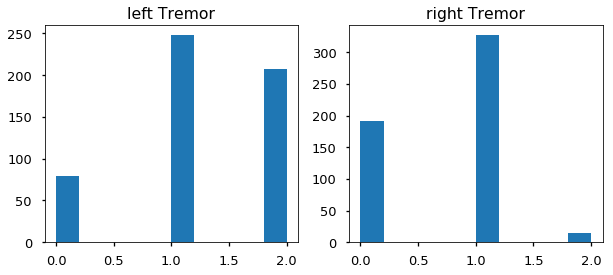

In [119]:
# symptom='Bradykinesia'
symptom='Tremor'

fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
ax1 = plt.hist(Data[Data['Location']=='dorsal_hand_left'].Bradykinesia)
plt.title('left '+symptom)
fig.add_subplot(122)
ax2 = plt.hist(Data[Data['Location']=='dorsal_hand_right'].Bradykinesia)
plt.title('right '+symptom)


In [120]:
#rows with symptoms 
indp = ((Data[symptom]>0))
indp = indp.values

In [121]:
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

Rows w Tremor 444/1068 = 0.42


# PCA on features to visualize subjects with symptom


In [122]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [123]:
#standardize features
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

(1068, 60)


total explained variance ratio (first 10 components): 0.700
[ 0.32053414  0.0860509   0.06128759  0.04636548  0.04210136  0.03447025
  0.03209287  0.02941163  0.02577884  0.02200342]


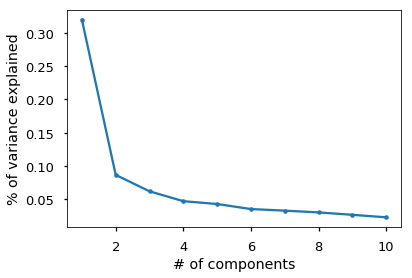

In [124]:
%matplotlib inline
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
ax = plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [125]:
Xpca.shape

(1068, 10)

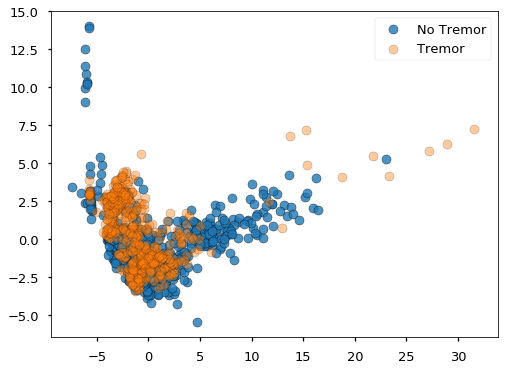

In [126]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
plt.legend()

# Fit an LDA to the data

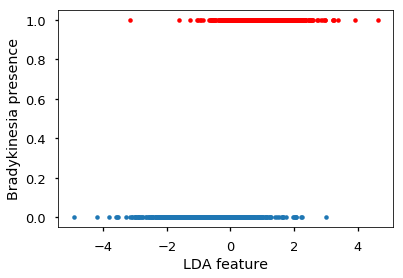

In [127]:
y = indp.astype(int) #label values
X_std.shape
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_std,y)
fig=plt.figure()
plt.plot(X_lda[~indp],np.zeros((X_lda[~indp].shape[0],1)),'.')
plt.plot(X_lda[indp],np.ones((X_lda[indp].shape[0],1)),'r.')
plt.xlabel('LDA feature')
plt.ylabel('Bradykinesia presence')
# X_lda_df = pd.DataFrame(data=np.hstack((X_lda,indp)),columns=['lda_feature','bradykinesia'])
# X_lda_df.head()

# Fit some classifiers to data using LOSOCV

In [128]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

### Helper fcns

In [171]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Bradykinesia','No-symptom'], rotation=45)
    plt.yticks(tick_marks, ['Bradykinesia','No-symptom'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; acc_all=[]; acc_train=[] #sens and spec for current model and all subject

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
            else:
                print('%s has no positive examples'%Data.Subject[test_index].unique())
                Sens = np.nan
            if np.sum(yte==0)>0:
                Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
            else:
                Spec = np.nan
                print('%s has no negative examples'%Data.Subject[test_index].unique())
            Sens_all.append(Sens); Spec_all.append(Spec)
            #compute accuracy
            acc = sum(ypred==yte)/len(yte)
            acc_all.append(acc)
        
        #mean across all subjects
        print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
        print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
        print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
        print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
        

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [130]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1044, 1046,
       1049])

In [131]:
#LOSO CV
groups = Data.Subject.as_matrix()

In [172]:
models = [LogisticRegression(penalty='l1',random_state=2),
          RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',cache_size=800,probability=True,random_state=3),
          XGBClassifier()
         ]
model_name = ['LR','Random Forest','Gradient Boosting','SVM','XGB']
models = list(zip(models,model_name))
# models_list = list(models) #to save it as a list

In [173]:
y = indp.astype(int) #target 

In [174]:
LOSOCV(Data,X_std,y,groups,models)

Training LR
[1020] has no positive examples
[1046] has no positive examples
LR, mean Acc on training set = 0.843 (+/- 0.008)
LR, mean Sens = 0.602 (+/- 0.165)
LR, mean Spec = 0.729 (+/- 0.141)
LR, mean Acc = 0.709 (+/- 0.110)
Training Random Forest
[1020] has no positive examples
[1046] has no positive examples
Random Forest, mean Acc on training set = 1.000 (+/- 0.000)
Random Forest, mean Sens = 0.487 (+/- 0.211)
Random Forest, mean Spec = 0.773 (+/- 0.128)
Random Forest, mean Acc = 0.677 (+/- 0.122)
Training Gradient Boosting
[1020] has no positive examples
[1046] has no positive examples
Gradient Boosting, mean Acc on training set = 0.949 (+/- 0.004)
Gradient Boosting, mean Sens = 0.526 (+/- 0.210)
Gradient Boosting, mean Spec = 0.741 (+/- 0.095)
Gradient Boosting, mean Acc = 0.666 (+/- 0.098)
Training SVM
[1020] has no positive examples
[1046] has no positive examples
SVM, mean Acc on training set = 0.887 (+/- 0.004)
SVM, mean Sens = 0.529 (+/- 0.195)
SVM, mean Spec = 0.742 (+/- 0.

## Feature importance

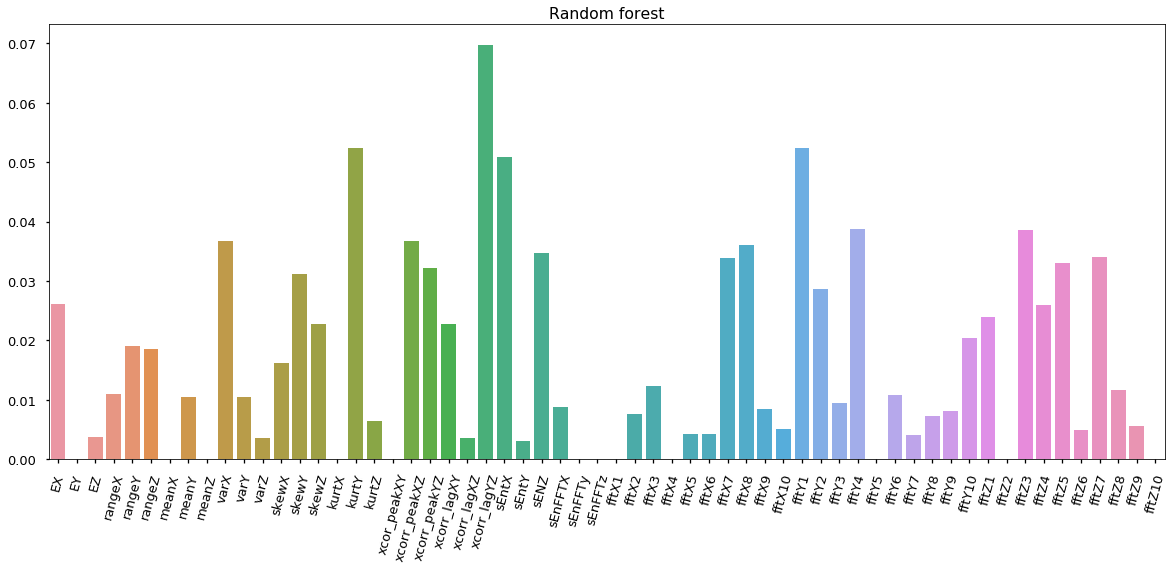

In [181]:
clf = models[1][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Random forest')

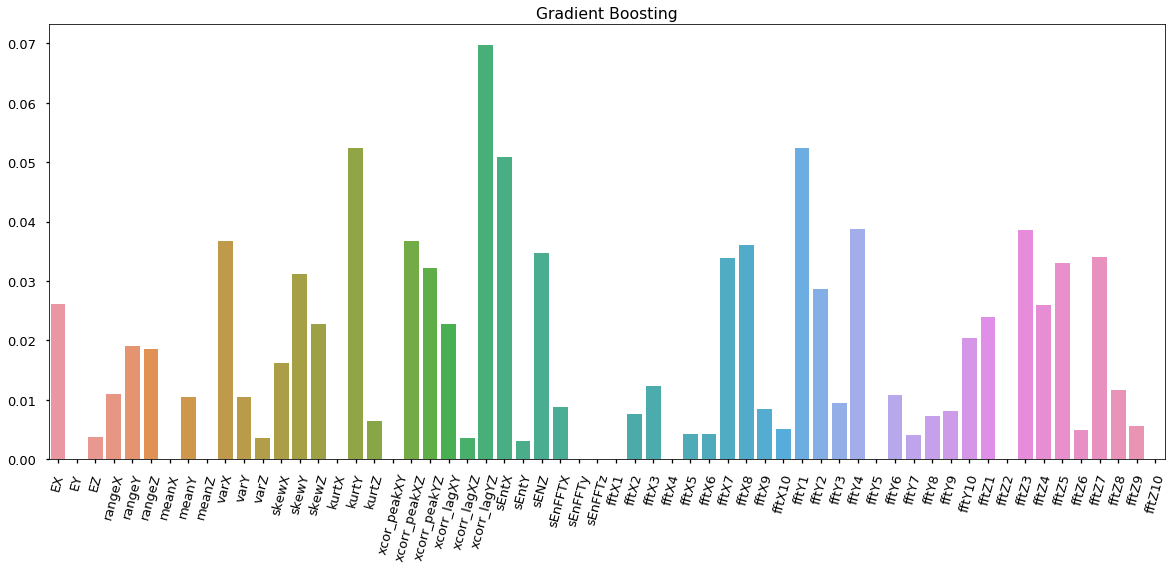

In [180]:
clf = models[2][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Gradient Boosting')

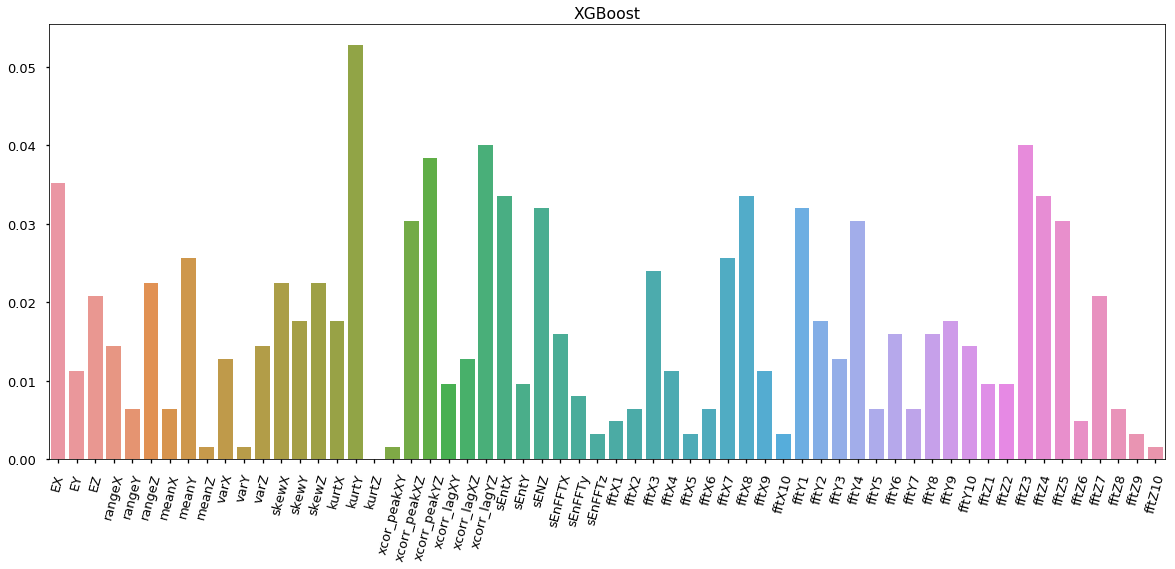

In [187]:
clf = models[4][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost')